In [1]:
!pip install IPython 

#### colab에서 실행시 다음 주석문을 풀어 실행시킨다.

In [2]:

from google.colab import drive
drive.mount('/gdrive',force_remount=True)


Mounted at /gdrive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,datasets

from sklearn.model_selection import train_test_split
from copy import deepcopy
from IPython.display import Image

In [4]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('device_check:',device)

device_check: cuda


# Load CIFAR 10 Dataset

In [48]:
trainset=datasets.CIFAR10(root = './data', train = True, download = True)
testset = datasets.CIFAR10(root = './data', train = False, download = True)

X_data, Y_data = trainset.data, np.array(trainset.targets)

Files already downloaded and verified
Files already downloaded and verified


#### sample the dataset

In [77]:
shuffle_mask=np.arange(X_data.shape[0])
np.random.shuffle(shuffle_mask)

X_data= X_data[shuffle_mask]
Y_data= Y_data[shuffle_mask]

X_train = X_data[:20000]
X_test = X_data[20000:24000]
Y_train = Y_data[:20000]
Y_test = Y_data[20000:24000]


X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2)

print('----Train data info----')
print(X_train.shape)
print(Y_train.shape)

print('----Validation data info----')
print(X_valid.shape)
print(Y_valid.shape)

print('----Test data info----')
print(X_test.shape)
print(Y_test.shape)

----Train data info----
(16000, 32, 32, 3)
(16000,)
----Validation data info----
(4000, 32, 32, 3)
(4000,)
----Test data info----
(4000, 32, 32, 3)
(4000,)


####  image print

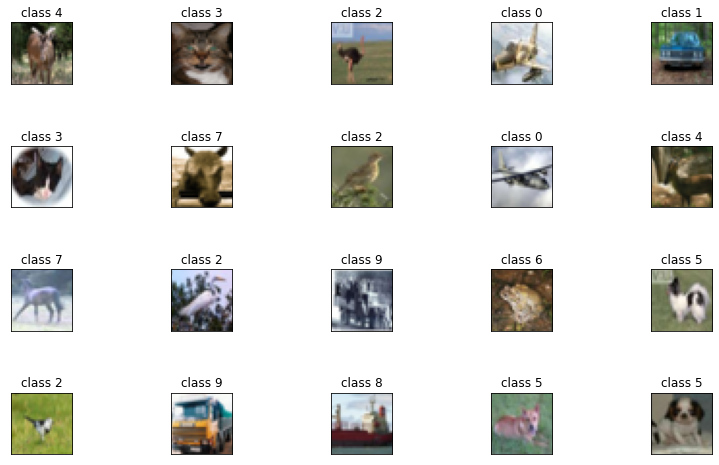

In [78]:
### cifar10 이미지 출력 ###

sample_X = X_train[:20]
sample_Y = Y_train[:20]

fig = plt.figure()
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=1, hspace=1)
for i in range(20):
    subplot = fig.add_subplot(4, 5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('class %d'%sample_Y[i])
    subplot.imshow(sample_X[i], cmap=plt.cm.gray_r)
plt.show()

In [79]:
class Custom_Dataset(Dataset):
    def __init__(self, X, y):
        self.X=np.transpose(X/255.0,(0,3,1,2))
        self.y=y

    def __len__(self):
        
        result=len(self.X)
    
        return result
    
    def __getitem__(self, idx):
        
        result_X=self.X[idx]
        result_y=self.y[idx]
        return result_X,result_y

#### [문제 01] Flatten Function(Flatten Layer)

Flatten layer는 CNN의 데이터 타입을 Fully Connected Neural Network의 형태로 변경하는 layer이다.
flatten 함수를 통해 flatten layer를 구현하시오.
(바꾸는 방법은 다양함.) (10점)

![nn](img/flatten.png)

In [80]:

def flatten(x):
    data=x.shape[0]
    ###################### Write Your Code Here ###################
    flatten_x = torch.flatten(x,1)
    ###############################################################
    return flatten_x


#### [문제 02] Multi Layer Perceptron(MLP)
전체 layer의 개수가 5개 이상 10개 이하인  Multi-layer Perceptron(MLP)를 만드시오. MLP model은 test dataset에 대해 40%     이상의 Test accuracy를 가져야 한다.


(단 activation function은 self.activation_func을 사용해야 한다.) 

(** HINT: pytorch의 nn.Sequential을 찾아보고 사용해볼것.) (25점)

In [81]:

class MLP(nn.Module):
    def __init__(self,input_size,active_func,output_size):
        super(MLP,self).__init__()
        
        self.activation_func=active_func
        ######################## Write your Code Here ########################
        self.seq = nn.Sequential(
            nn.Linear(input_size,512),
            self.activation_func,
            nn.Linear(512,256),
            self.activation_func,
            nn.Linear(256,128),
            self.activation_func,
            nn.Linear(128,64),
            self.activation_func,
            nn.Linear(64,32),
            self.activation_func,
            nn.Linear(32,output_size)
        )
        #######################################################################
        
    def forward(self,x):
        x = flatten(x)  # flatten layer: 위에서 정의한 flatten 함수를 먼저 작성해야 한다.
        x = self.seq(x) # 입력값이 하나인 것을 생각하고 network를 짜야한다.
        return x
        

##### [문제 03] Convolutional Neural Network

INPUT(32X32X3) --> CONV1(30X30X12) --> CONV2(28X28X12) --> POOL1(14X14X12) --> CONV3(12X12X24) --> CONV4(10X10X24) --> POOL2(5X5X24) --> FC --> ... -->FC(class num)를 따르는 CNN model을 만드시오.
FC층은 2개에서 4개 사이의 층을 가지도록 구성한다.단 Test dataset에 대해 50% 이상의 Test accuracy를 가져야 한다. (30점)
(activation function은 self.activation_func을 사용할 것.)


In [82]:
class CNNModel(nn.Module):
    def __init__(self,input_channel,active_func):
        super(CNNModel, self).__init__()
        
        self.activation_func=active_func
        ######################## Write your Code Here #########################
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3))
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3))
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=(3, 3))
        self.maxpool2 = nn.MaxPool2d(2)
		    
        self.fc1 = nn.Linear(in_features=600, out_features=300)
        self.fc2 = nn.Linear(in_features=300, out_features=10)

        self.logSoftmax = nn.LogSoftmax(dim=1)
        #######################################################################

    def forward(self, output):
        ######################## Write your Code Here #########################
        output = self.conv1(output)
        self.activation_func
        output = self.conv2(output)
        self.activation_func
        output = self.maxpool1(output)
		
        output = self.conv3(output)
        self.activation_func
        output = self.conv4(output)
        self.activation_func
        output = self.maxpool2(output)

        output = torch.flatten(output, 1)
        output = self.fc1(output)
        self.activation_func
		
        output = self.fc2(output)
        output = self.logSoftmax(output)

        return output
        #######################################################################




In [83]:
## train func
def train(model, epoches, train_loader, val_loader, optimizer, criteria):
    best_score = 0
    best_model = None
    batch_len = len(train_loader)
    val_acc = []
    for epoch in range(epoches):
        total_loss = 0;train_acc=0.0;correct = 0
        for i,data in enumerate(train_loader):
            image,label=data
            image = torch.tensor(image, device = device)
            label = torch.tensor(label, device = device)
            model.train() 
            optimizer.zero_grad() 
            output=model(image.float())
            prediction=output.max(1,keepdim=True)[1]
            loss=criteria(output,label.long())
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            loss.backward() 
            optimizer.step()
            train_accuracy = 100. * correct / len(train_loader.dataset)
            
            # loss
            total_loss+=loss.item()             
        
            if i % batch_len == batch_len-1:
                print('{}th epoch loss:{:.6f} Train Acc:{}'.format(epoch+1,total_loss/batch_len,train_accuracy))

                total_loss = 0

                val_score = evaluate(model,val_loader)
                val_acc.append(val_score)
                if val_score>=best_score:
                    best_score=val_score 
                    best_model=deepcopy(model)

    return best_model, val_acc

## evaluation func
def evaluate(model, test_loader):
    model.eval()

    correct = 0
    with torch.no_grad():
        for data in test_loader:
            image,label=data
            image = image.to(device)
            label = label.to(device)
            output = model(image.float())
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_accuracy


In [84]:
def choice_activation(name):
    if name=="sigmod":
        function=nn.Sigmoid()
    elif name=="relu":
        function=nn.ReLU()
    elif name=="tanh":
        function=nn.Tanh()
    elif name=="leakyrelu":
        function=nn.LeakyReLU()
    return function

#### [문제 04] Activation Function

위에서 정의한 choice_activation()을 통해 4가지 중 하나의 activation function을 선택해 active_function 변수에 저장하고, 
해당 activation function을 선택한 이유를 보고서에 서술하시오. (5점)

============== MLP Train Start ================


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


1th epoch loss:2.135404 Train Acc:18.45
2th epoch loss:1.988587 Train Acc:25.29375
3th epoch loss:1.922142 Train Acc:28.6
4th epoch loss:1.841757 Train Acc:32.3875
5th epoch loss:1.788615 Train Acc:34.65625
6th epoch loss:1.748214 Train Acc:36.38125
7th epoch loss:1.712616 Train Acc:38.3125
8th epoch loss:1.679457 Train Acc:39.3625
9th epoch loss:1.644512 Train Acc:40.66875
10th epoch loss:1.606651 Train Acc:42.0875
11th epoch loss:1.572885 Train Acc:43.275
12th epoch loss:1.544921 Train Acc:44.35625
13th epoch loss:1.518695 Train Acc:45.38125
14th epoch loss:1.489760 Train Acc:46.61875
15th epoch loss:1.469690 Train Acc:47.25625
16th epoch loss:1.443774 Train Acc:48.475
17th epoch loss:1.424720 Train Acc:48.7
18th epoch loss:1.400913 Train Acc:49.65
19th epoch loss:1.390631 Train Acc:49.8875
20th epoch loss:1.378418 Train Acc:50.2375
----------- MLP Test Result ----------------
MLP Test Accuracy: 42.175
============== CNN Train Start ================
1th epoch loss:1.906791 Train Acc:

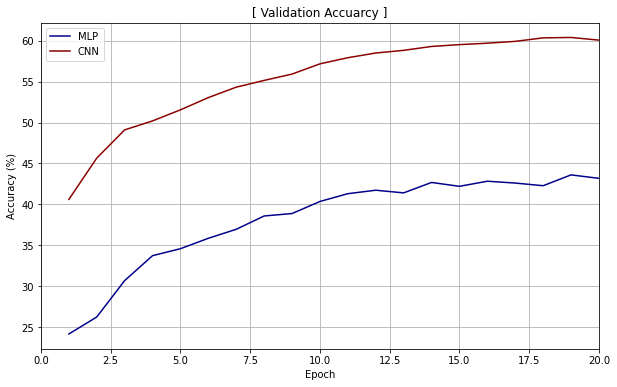

In [85]:
# hyperparameter
EPOCHS=20
LEARNING_RATE=1e-3

## 배치 사이즈는 사양에 맞게  변경이 가능하다.
###################################
BATCH_SIZE=128
####################################

train_loader = DataLoader(Custom_Dataset(X_train,Y_train), batch_size = BATCH_SIZE)
val_loader = DataLoader(Custom_Dataset(X_valid,Y_valid), batch_size = BATCH_SIZE)
test_loader = DataLoader(Custom_Dataset(X_test,Y_test), batch_size = BATCH_SIZE)



########## Write Your Code Here #########
active_function=choice_activation("relu")
#########################################
criterion=nn.CrossEntropyLoss()


input_channel=X_train.shape[3]
input_size=X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
output_size=len(np.unique(Y_train))


mlp_model=MLP(input_size,active_function,output_size)
mlp_model.to(device)
mlp_optimizer=torch.optim.Adam(mlp_model.parameters(),lr=LEARNING_RATE)
criterion=nn.CrossEntropyLoss() 

cnn_model=CNNModel(input_channel,active_function)
cnn_model.to(device)

cnn_optimizer=torch.optim.Adam(cnn_model.parameters(),lr=LEARNING_RATE)


# train mlp and test mlp

print("============== MLP Train Start ================")
best_mlp,mlp_val_acc=train(mlp_model,EPOCHS,train_loader, val_loader,mlp_optimizer,criterion)
mlp_acc=evaluate(best_mlp,test_loader)
print('----------- MLP Test Result ----------------')
print('MLP Test Accuracy:',mlp_acc)


# train cnn and test cnn
print("============== CNN Train Start ================")
best_cnn,cnn_val_acc=train(cnn_model,EPOCHS,train_loader, val_loader,cnn_optimizer,criterion)
cnn_acc=evaluate(best_cnn,test_loader)
print('----------- CNN Test Result ----------------')
print('CNN Test Accuracy:',cnn_acc)


### Graph Shows ####

plt.rcParams["figure.figsize"]=(10,6)
plt.title('[ Validation Accuarcy ]')

plt.plot(np.arange(1,len(mlp_val_acc)+1),mlp_val_acc,label='validation',color='darkblue')
plt.plot(np.arange(1,len(cnn_val_acc)+1),cnn_val_acc,label='validation',color='darkred')
plt.xlim([0,20])
plt.legend(['MLP','CNN'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()
